In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import pandas_profiling

import env
import acquire
import prep
import explore_final
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols

## Planning and Initial Hypothesis

##### Initial Hypothesis: Square footage and home value extremes are leading drivers of log error.

##### Goal

- Improve model to be better than baseline for log error. 
- Find key drivers of log error.

##### Planning

Discussed possibly strong drivers of log error. Initial assumptions were tax value.

Outlined rough work split between partners.

## Acquire and summarize data

Initial Dataframe included single family residence homes with 40+ initial fields brought in.

After reviewing the data for missing values, multicollinearity, and low correlation we dropped our data down to 14 columns and 54,000 rows. 300 values were imputed on lotsizesquarefeet with the mean in order to maintain the column.

In [2]:
#nmysql query single family residence from zillow DB
df = prep.prep_df_initial()

In [3]:
df.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,logerror
0,2.0,4.0,3633.0,296425.0,34560018.0,-118169806.0,9826.000000,222321.0,0.042463
1,4.0,3.0,1620.0,847770.0,33996200.0,-118438000.0,12842.749037,339532.0,-0.019546


## Data prep and test/train split

Our initial dataframe was split into 70/30 train/test adding a tax_per_sqft field. Random State 123 was used.

In [4]:
#train test split and adding a tax_per_sqft field
train, test = prep.get_train_and_test(df)

In [5]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,logerror,tax_per_sqft
45911,4.0,3.0,3400.0,1621085.0,34115399.0,-118428166.0,17050.0,324211.0,0.041261,476.789706
11373,3.0,4.0,2805.0,621455.0,34200510.0,-118920525.0,7067.0,372876.0,-0.409181,221.552585


## Initial exploration and feature selection

In [6]:
#adding a baseline yhat as mean of log error and residual amt based off that.
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

In [7]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,logerror,tax_per_sqft,mean_logerror,residual
45911,4.0,3.0,3400.0,1621085.0,34115399.0,-118428166.0,17050.0,324211.0,0.041261,476.789706,0.016716,0.024546
11373,3.0,4.0,2805.0,621455.0,34200510.0,-118920525.0,7067.0,372876.0,-0.409181,221.552585,0.016716,-0.425896


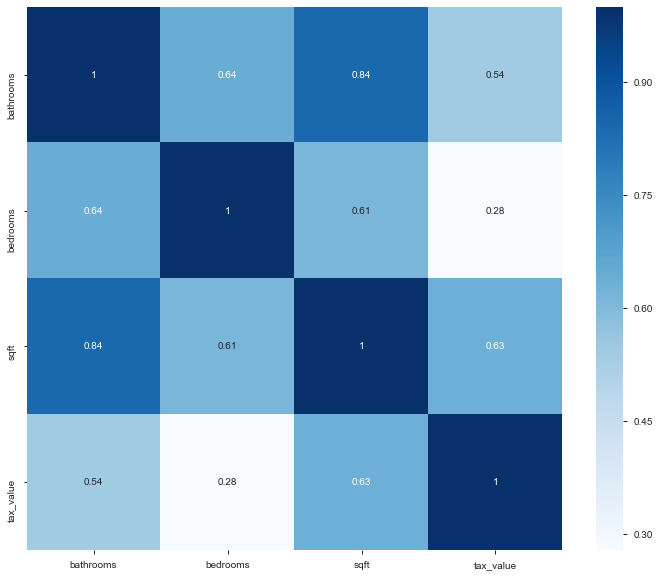

In [8]:
# Heatmap of possible initial features
plt.figure(figsize=(12,10))
subset = df[['bathrooms','bedrooms','sqft','tax_value']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [9]:
X_train, y_train, X_test, y_test = prep.get_baseline_train_test_split(df)

In [10]:
X_train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt
45911,4.0,3.0,3400.0,1621085.0,34115399.0,-118428166.0,17050.0,324211.0
11373,3.0,4.0,2805.0,621455.0,34200510.0,-118920525.0,7067.0,372876.0


## Initial Baseline Model

In [11]:
baseline = mean_squared_error(train.logerror,train.mean_logerror)
print(baseline)

0.02860151953645495


## MVP

After some basic feature engineering and selection we trained the new model on just sqft and bedrooms. This model performed slightly better than our baseline.

In [12]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)

In [13]:
model1 = mean_squared_error(train.logerror,train.yhat)
print(model1)
model1 < baseline

0.028601320888745733


True

## Exploration

We began our exploration by clustering on the y variable.

   k          sse
0  1  1112.742118
1  2   676.526617
2  3   480.181422
3  4   332.524531
4  5   249.052507
5  6   181.808764
6  7   138.445601
7  8   109.135239
8  9    89.888920


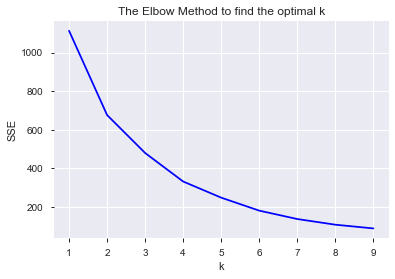

In [14]:
y_train = pd.DataFrame(y_train)
explore_final.elbow_plot(y_train)

In [15]:
#Logerror clusters. Function takes y,X, and num_clusters
train = explore_final.target_cluster(y_train,X_train,6)

In [16]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,,
5,2.321429,3.257143,1914.757143,526014.442857,3.400837e+07,-1.181988e+08,9661.785714,173839.628571,-1.342703
2,2.220940,3.293236,1850.620494,450385.152288,3.401324e+07,-1.182036e+08,9787.698953,175942.993053,-0.201603
0,2.254168,3.313137,1868.007177,455454.605157,3.401600e+07,-1.182079e+08,10231.163356,177777.565600,0.001528
4,2.253329,3.302032,1866.446391,458259.373511,3.401727e+07,-1.182041e+08,9657.319198,178734.844826,0.160047
3,2.263780,3.368110,1914.586614,444542.374016,3.401250e+07,-1.181825e+08,12177.069118,185698.411263,0.636575
1,2.308140,3.209302,1776.465116,402307.674419,3.404162e+07,-1.182328e+08,13551.971752,158912.166935,2.155776


### Target clustering

The crosstab above shows the clusters sorted by lowest average log error to highest. The summary data shows that the largest/most expensive, and smallest/least expensive houses had the largest absolute value logerrors.

Unfortunately...this was due to our clusters being very disproportionate in size.

This outcome still gave us valuable insight that the logerror was less accurate the further it moved from the median price/sqft.

In [17]:
train.cluster.value_counts()

0    31491
4     4281
2     2469
3      508
1       86
5       70
Name: cluster, dtype: int64

### Variable clustering

After exploring bedrooms and bathrooms differences with ttests we discovered they were not providing value and were dropped. 

The decision was also made to drop region based location variables (city, zipcode, etc) from this model in order to isolate only on features related to the houses specfically. 

In [18]:
#updated dataframe to only include final x variables
df = prep.prep_df()
df = df.drop(columns=['latitude','longitude'])

df.head(2).T

In [19]:
train, test = prep.get_train_and_test(df)
train = train.drop(columns='tax_value')
test = test.drop(columns='tax_value')
X_train, y_train, X_test, y_test = prep.get_train_test_split(train, test)

In [20]:
X_train.head(2)

,sqft,lotsizesquarefeet,structuretaxvaluedollarcnt,tax_per_sqft
45911,3400.0,17050.0,324211.0,476.789706
11373,2805.0,7067.0,372876.0,221.552585


In [ ]:
explore_final.elbow_plot(X_train)

In [ ]:
X_train, X_test, kmeans = explore_final.x_cluster(X_train,X_test,6)

In [ ]:
X_train.x_cluster.value_counts()

In [ ]:
#updated model with x_cluster as variable, only use 4 largest clusters- Jeff

In [ ]:
# add outlier uneveness plots - Symeon

In [ ]:
# add stratification - Symeon

In [ ]:
# improved model - Symeon

In [ ]:
# add notes about what this is showing


explore_final.logerror_outliers()

In [ ]:
# takeaways and conclusions

rejected null hypothesis

bedrooms and sqft performed slightly better than baseline

determined test/train split was not normally dist on log error

key drivers of log error were price per sqft and tax value. The outliers are driving higher log error
